# Team formation using MAB

In [1]:
# Omid55
import numpy as np
import random as rand
import scipy.stats as stat
import math
import itertools as itt
import collections
import matplotlib.pyplot as plt
import time
%matplotlib inline
import seaborn as sns
import pandas as pd

# Problem definition

In [3]:
'''Problem class'''
class Problem:
    # npeople
    # weights
    # team_size
    # optimal_team

    def __init__(self, npeople, team_size):
        self.npeople = npeople
        self.team_size = team_size
        self.all_possible_teams = list(itt.combinations(range(0, self.npeople), self.team_size))
        self.weights = np.random.rand(npeople, npeople)
        self.weights = np.maximum(self.weights, self.weights.transpose())
        np.fill_diagonal(self.weights, 0)
        self.optimal_team = []
        self.STOCHASTICITY = 0.05

    def set_weights(self, weights):
        self.weights = weights

    def pull_arm(self, team):    # objective (fitness) function
        assert len(team) == self.team_size, 'team size should not be different than ' + self.team_size + ' .'
        prob = (1-self.STOCHASTICITY) * self.compute_value_of_team(team) / self.compute_value_of_team(self.optimal_team)
        return stat.bernoulli.rvs(prob)    #stat.binom.rvs(1, prob)

    def compute_value_of_team(self, team):
        w = 0.0
        c = 0.0
        for i in range(0, len(team)-1):
            for j in range(i+1, len(team)):
                w += self.weights[team[i]][team[j]]
                c += 1.0
        return w / c

# Optimal solution

In [4]:
'''Different methods for choosing team'''
# ground truth
def choose_optimal_team(problem, iterations):
    for it in range(iterations):
        if not problem.optimal_team:
            max_v = -999
            for team in problem.all_possible_teams:
                v = problem.compute_value_of_team(team)
                if v > max_v:
                    problem.optimal_team = team
                    max_v = v
            print('The optimal team is => ', problem.optimal_team, '\n')
        reward = problem.pull_arm(problem.optimal_team)
        yield problem.optimal_team, reward

# Methods

In [5]:
def choose_team_by_random(problem, iterations):
    for it in range(iterations):
        team = rand.sample(range(problem.npeople), problem.team_size)
        reward = problem.pull_arm(team)
        yield team, reward

In [6]:
def choose_team_by_explore_few_then_exploit(problem, iterations):  # Maximum Likelihood
    exploration_percent = 10
    exploration_count = iterations * exploration_percent/100.0
    teams = []
    S = collections.defaultdict(lambda: 0)
    F = collections.defaultdict(lambda: 0)
    for it in range(iterations):
        if it < exploration_count:
            team = sorted(rand.sample(range(problem.npeople), problem.team_size))
            reward = problem.pull_arm(team)
            if reward == 1:
                S[str(team)[1:-1]] += 1
            else:
                F[str(team)[1:-1]] += 1
            yield team, reward
        else:
            if not teams:
                teams = list(set(list(S.keys())+list(F.keys())))
            prob = [S[a]/(S[a]+F[a]) for a in teams]
            team_str = teams[np.argmax(prob)]
            team = list(map(int, team_str.split(',')))
            reward = problem.pull_arm(team)
            if reward == 1:
                S[team_str] += 1
            else:
                F[team_str] += 1
            yield team, reward

In [7]:
def choose_team_by_ucb(problem, iterations):
    tn = len(problem.all_possible_teams)
    assert iterations>tn, 'Number of iterations should be larger than number of teams.'
    S = collections.defaultdict(lambda: 0)
    F = collections.defaultdict(lambda: 0)
    for team in problem.all_possible_teams:
        reward = problem.pull_arm(team)
        team_str = str(team)[1:-1]
        if reward == 1:
            S[team_str] += 1
        else:
            F[team_str] += 1
        yield team, reward
    for it in range(iterations-tn):
        prob = [S[str(t)[1:-1]]/float(S[str(t)[1:-1]]+F[str(t)[1:-1]]) + math.sqrt(2*math.log(it+tn)/float(S[str(t)[1:-1]]+F[str(t)[1:-1]])) for t in problem.all_possible_teams]
        team = problem.all_possible_teams[np.argmax(prob)]
        reward = problem.pull_arm(team)
        team_str = str(team)[1:-1]
        if reward == 1:
            S[team_str] += 1
        else:
            F[team_str] += 1
        yield team, reward

In [8]:
def choose_team_by_thompson_sampling(problem, iterations):
    tn = len(problem.all_possible_teams)
    S = collections.defaultdict(lambda: 0)
    F = collections.defaultdict(lambda: 0)
    for it in range(iterations):
        sampled_params = np.zeros(tn)
        for t, team in enumerate(problem.all_possible_teams):
            team_str = str(team)[1:-1]
            alpha = S[team_str] + 1
            beta = F[team_str] + 1
            sampled_params[t] = stat.beta.rvs(alpha, beta)
        team = problem.all_possible_teams[np.argmax(sampled_params)]
        reward = problem.pull_arm(team)
        team_str = str(team)[1:-1]
        if reward == 1:
            S[team_str] += 1
        else:
            F[team_str] += 1
        yield team, reward

In [9]:
def choose_team_by_ucb_with_random_variable_for_each_edge(problem, iterations):
    tn = len(problem.all_possible_teams)
    assert iterations>tn, 'Number of iterations should be larger than number of teams.'
    S = collections.defaultdict(lambda: 0)
    F = collections.defaultdict(lambda: 0)
    # nn = 2.0 / (len(team) * (len(team)-1))
    nn = 1
    for team in problem.all_possible_teams:
        reward = problem.pull_arm(team)
        for i in range(0, len(team) - 1):
            for j in range(i + 1, len(team)):
                edge = str(team[i]) + ',' + str(team[j])
                edge_rev = str(team[j]) + ',' + str(team[i])
                if reward == 1:
                    S[edge] += nn
                    S[edge_rev] += nn
                else:
                    F[edge] += nn
                    F[edge_rev] += nn
        yield team, reward
    for it in range(iterations-tn):
        prob = np.zeros(tn)
        for index, team in enumerate(problem.all_possible_teams):
            for i in range(0, len(team) - 1):
                for j in range(i + 1, len(team)):
                    edge = str(team[i]) + ',' + str(team[j])
                    nk = float(S[edge]+F[edge])
                    prob[index] += S[edge] / nk + math.sqrt(2 * math.log(it + tn) / nk)
        team = problem.all_possible_teams[np.argmax(prob)]
        reward = problem.pull_arm(team)
        for i in range(0, len(team) - 1):
            for j in range(i + 1, len(team)):
                edge = str(team[i]) + ',' + str(team[j])
                edge_rev = str(team[j]) + ',' + str(team[i])
                if reward == 1:
                    S[edge] += nn
                    S[edge_rev] += nn
                else:
                    F[edge] += nn
                    F[edge_rev] += nn
        yield team, reward

In [10]:
def choose_team_by_thompson_sampling_with_random_variable_for_each_edge(problem, iterations):
    tn = len(problem.all_possible_teams)
    S = collections.defaultdict(lambda: 0)
    F = collections.defaultdict(lambda: 0)
    # nn = 2.0 / (len(team) * (len(team)-1))
    nn = 1
    for it in range(iterations):
        sampled_params = np.zeros(tn)
        for t, team in enumerate(problem.all_possible_teams):
            alpha = 1
            beta = 1
            for i in range(0,len(team)-1):
                for j in range(i+1, len(team)):
                    edge = str(team[i])+','+str(team[j])
                    # if S[edge] + F[edge] != 0:
                    #     alpha += S[edge] / (S[edge] + F[edge])
                    #     beta += F[edge] / (S[edge] + F[edge])
                    alpha += S[edge]
                    beta += F[edge]
            sampled_params[t] = stat.beta.rvs(alpha, beta)
        team = problem.all_possible_teams[np.argmax(sampled_params)]
        reward = problem.pull_arm(team)
        for i in range(0,len(team)-1):
            for j in range(i+1, len(team)):
                edge = str(team[i]) + ',' + str(team[j])
                edge_rev = str(team[j]) + ',' + str(team[i])
                if reward == 1:
                    S[edge] += nn
                    S[edge_rev] += nn
                else:
                    F[edge] += nn
                    F[edge_rev] += nn
        yield team, reward

In [11]:
def choose_team_by_thompson_sampling_with_keep_track_of_edge_and_team(problem, iterations):
    tn = len(problem.all_possible_teams)
    S_edge = collections.defaultdict(lambda: 0)
    F_edge = collections.defaultdict(lambda: 0)
    S_team = collections.defaultdict(lambda: 0)
    F_team = collections.defaultdict(lambda: 0)
    # nn = 2.0 / (len(team) * (len(team)-1))
    nn = 1
    for it in range(iterations):
        sampled_params = np.zeros(tn)
        for t, team in enumerate(problem.all_possible_teams):
            team_str = str(team)[1:-1]
            alpha = 1
            beta = 1
            for i in range(0,len(team)-1):
                for j in range(i+1, len(team)):
                    edge = str(team[i])+','+str(team[j])
                    # if S_team[team_str]:
                    #     alpha += S_team[team_str] * S_edge[edge]
                    # else:
                    #     alpha += S_edge[edge]
                    # if F_team[team_str]:
                    #     beta += F_team[team_str] * F_edge[edge]
                    # else:
                    #     beta += F_edge[edge]
                    alpha += S_team[team_str] * S_edge[edge]
                    beta += F_team[team_str] * F_edge[edge]
            sampled_params[t] = stat.beta.rvs(alpha, beta)
        team = problem.all_possible_teams[np.argmax(sampled_params)]
        reward = problem.pull_arm(team)
        selected_team_str = str(team)[1:-1]
        if reward == 1:
            S_team[selected_team_str] += nn
        else:
            F_team[selected_team_str] += nn
        for i in range(0,len(team)-1):
            for j in range(i+1, len(team)):
                edge = str(team[i]) + ',' + str(team[j])
                edge_rev = str(team[j]) + ',' + str(team[i])
                if reward == 1:
                    S_edge[edge] += nn
                    S_edge[edge_rev] += nn
                else:
                    F_edge[edge] += nn
                    F_edge[edge_rev] += nn
        yield team, reward

The optimal team is =>  (1, 4, 5, 9) 

choose_optimal_team =>	last team:  (1, 4, 5, 9) = 0.801533052688 ,	rewards:  0.9487999999999996 +/- 0.0 , in  0.36  seconds.
choose_team_by_random =>	last team:  [8, 5, 0, 2] = 0.409479958153 ,	rewards:  0.7459999999999997 +/- 0.01 , in  0.39  seconds.
choose_team_by_explore_few_then_exploit =>	last team:  [1, 4, 5, 9] = 0.801533052688 ,	rewards:  0.9120000000000007 +/- 0.0 , in  0.67  seconds.
choose_team_by_ucb =>	last team:  (0, 3, 7, 9) = 0.630788883848 ,	rewards:  0.752200000000001 +/- 0.01 , in  7.1  seconds.
choose_team_by_thompson_sampling =>	last team:  (2, 3, 6, 8) = 0.71249827651 ,	rewards:  0.8040000000000014 +/- 0.01 , in  48.34  seconds.
choose_team_by_ucb_with_random_variable_for_each_edge =>	last team:  (1, 4, 5, 9) = 0.801533052688 ,	rewards:  0.8426000000000003 +/- 0.01 , in  18.64  seconds.
choose_team_by_thompson_sampling_with_random_variable_for_each_edge =>	last team:  (2, 3, 4, 8) = 0.729049899924 ,	rewards:  0.8120000000000

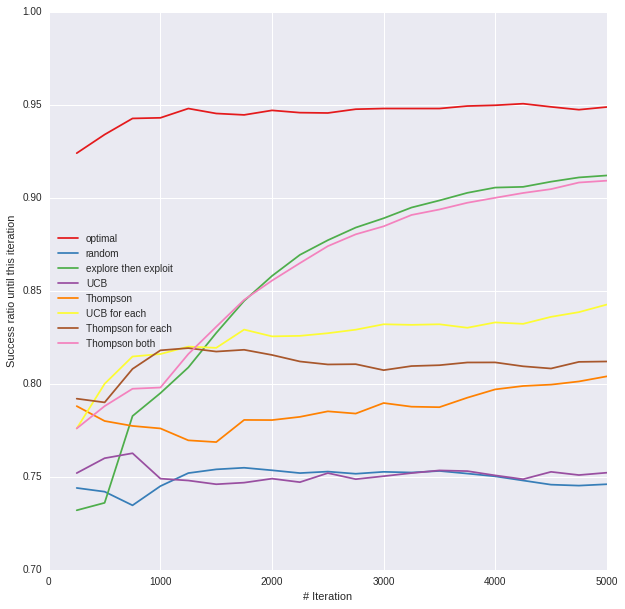

In [13]:
def main():
    
    auto = 1
    figure_points = 20

    if auto:
        # params
        number_of_people = 10
        team_size = 4
        iterations = 5000
        probl = Problem(number_of_people, team_size)
    else:
        number_of_people = 4
        team_size = 3
        iterations = 1000
        probl = Problem(number_of_people, team_size)
        #probl.set_weights([[0,0.75,0.06,0.3,0.5], [0.75,0,0.88,0.46,0.95], [0.06,0.88,0,0.7,0.9], [0.3,0.46,0.7,0,0.02], [0.5,0.95,0.9,0.02,0]])  # comment it out to see diverse problems << CHECK HERE >>
        probl.set_weights([[0, 0.1, 0.9, 0.2], [0.1, 0, 0.2, 0.3], [0.9, 0.2, 0, 0.3],[0.2, 0.3, 0.3, 0]])
        print(probl.weights, '\n\n')

    sns.set(rc={"figure.figsize": (10, 10)})
    sns.set_palette("Set1", 8)
    po = np.arange(iterations / figure_points, iterations + iterations / figure_points, iterations / figure_points)
    methods = [choose_optimal_team, choose_team_by_random, choose_team_by_explore_few_then_exploit, choose_team_by_ucb,
               choose_team_by_thompson_sampling, choose_team_by_ucb_with_random_variable_for_each_edge,
               choose_team_by_thompson_sampling_with_random_variable_for_each_edge, choose_team_by_thompson_sampling_with_keep_track_of_edge_and_team]
    for method in methods:
        start = time.time()
        rewards_mean = 0
        rewards_pow2_mean = 0
        success = np.zeros(figure_points)
        cnt = 0.0
        win = 0.0
        for team, reward in method(probl, iterations):
            rewards_mean = float(rewards_mean * cnt + reward) / (cnt + 1)
            rewards_pow2_mean = float(rewards_pow2_mean * cnt + reward*reward) / (cnt + 1)
            if reward:
                win += 1.0
            cnt += 1.0
            if not cnt % (iterations/figure_points):
                success[int(cnt / (iterations/figure_points))-1] = win / cnt

        plt.plot(po, success)
        rewards_std = round(math.sqrt(rewards_pow2_mean - rewards_mean*rewards_mean)/math.sqrt(iterations),2)
        print(method.__name__, '=>\tlast team: ', team, '=', probl.compute_value_of_team(team), ', rewards: ', rewards_mean, '+/-', rewards_std, ', in ', round(time.time() - start,2), ' seconds.')

    plt.xlabel('# Iteration')
    plt.ylabel('Success ratio until this iteration')
    plt.legend(['optimal', 'random', 'explore then exploit', 'UCB', 'Thompson', 'UCB for each', 'Thompson for each', 'Thompson both'], loc='best')
    plt.show()

    
    
# running the code
main()

The optimal team is =>  (1, 2, 4, 7) 



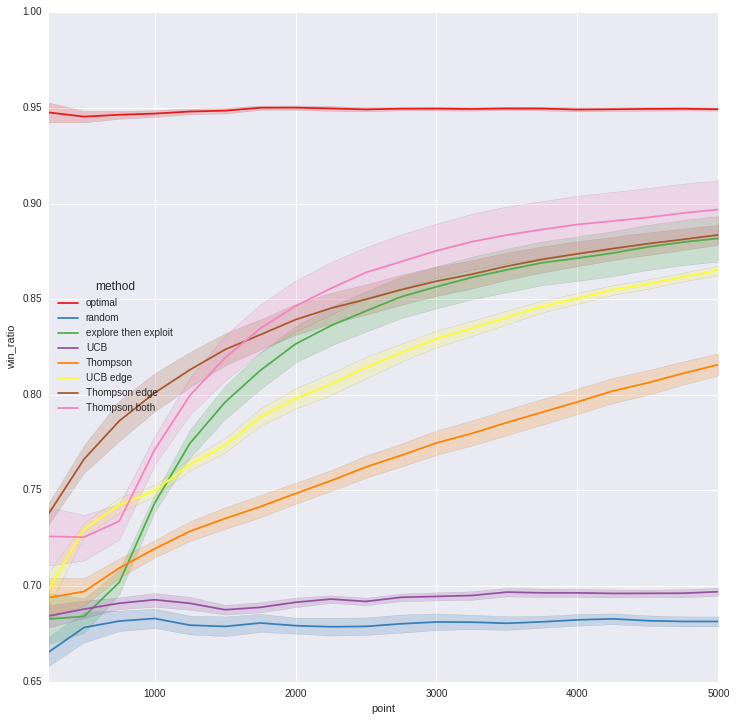

In [44]:
def main():
    
    auto = 1
    figure_points = 20
    runs = 10

    if auto:
        # params
        number_of_people = 10
        team_size = 4
        iterations = 5000
        probl = Problem(number_of_people, team_size)
    else:
        number_of_people = 4
        team_size = 3
        iterations = 1000
        probl = Problem(number_of_people, team_size)
        #probl.set_weights([[0,0.75,0.06,0.3,0.5], [0.75,0,0.88,0.46,0.95], [0.06,0.88,0,0.7,0.9], [0.3,0.46,0.7,0,0.02], [0.5,0.95,0.9,0.02,0]])  # comment it out to see diverse problems << CHECK HERE >>
        probl.set_weights([[0, 0.1, 0.9, 0.2], [0.1, 0, 0.2, 0.3], [0.9, 0.2, 0, 0.3],[0.2, 0.3, 0.3, 0]])
        print(probl.weights, '\n\n')

    sns.set(rc={"figure.figsize": (12, 12)})
    sns.set_palette("Set1", 8)
    po = np.arange(iterations / figure_points, iterations + iterations / figure_points, iterations / figure_points)
    methods = [choose_optimal_team, choose_team_by_random, choose_team_by_explore_few_then_exploit, choose_team_by_ucb,
               choose_team_by_thompson_sampling, choose_team_by_ucb_with_random_variable_for_each_edge,
               choose_team_by_thompson_sampling_with_random_variable_for_each_edge, choose_team_by_thompson_sampling_with_keep_track_of_edge_and_team]
    method_names = ['optimal', 'random', 'explore then exploit', 'UCB', 'Thompson', 'UCB edge', 'Thompson edge', 'Thompson both']
    success = pd.DataFrame(columns=['point', 'method', 'run', 'win_ratio'])
    c = 0
    for i, method in enumerate(methods):
        for run in range(runs):
            cnt = 0.0
            win = 0.0
            for team, reward in method(probl, iterations):
                if reward:
                    win += 1.0
                cnt += 1.0
                if not cnt % (iterations/figure_points):
                    success.loc[c] = [cnt, method_names[i], run, win / cnt]
                    c += 1
    ax = sns.tsplot(time='point', value='win_ratio', unit='run', condition='method', data=success)
    
    
# running the code
main()